# Sorting errors

author: steeve.laquitaine@epfl.ch

TODO:
- check source code to detect overmerging

Setup environment: 

```bash
pip install requirements_kilosort_silico
```

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np

proj_path = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(proj_path)

from src.pipes.sorting import match_sorted_to_true_neuropixels_2023_02_19 as match
from src.nodes.utils import get_config
from src.nodes.postpro.cell_matching import match_firing_rate, match_property
from src.nodes.postpro import feateng


# SET PARAMETERS
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_02_19"


# GET RUN CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()

CELL_MATCHING_PATH = data_conf["postprocessing"]["cell_matching"]

LOW_RATE_CEILING = 0.2  # max firing rate where negative proba change is observed in "bias plot"
MID_RATE_CEILING = 1    # max firing rate where positive proba change is observed in "bias plot"

ImportError: cannot import name 'match_sorted_to_true_neuropixels_2023_02_19' from 'src.pipes.sorting' (/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/pipes/sorting/__init__.py)

In [3]:
# get SpikeInterface's MatchingObject
out = match.run()

2023-04-27 11:38:43,513 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading kilosort3 Sorting Extractor
2023-04-27 11:38:43,559 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading kilosort3 Sorting Extractor - done: 0.0
2023-04-27 11:38:43,564 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading Ground truth Sorting Extractor
2023-04-27 11:38:43,599 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading Ground truth Sorting Extractor - done: 0.0
2023-04-27 11:39:12,537 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - Detecting true cell oversplit - done
2023-04-27 11:39:12,545 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - Detecting true cell misses - done


/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/pipes/sorting/match_sorted_to_true_neuropixels_2023_02_19.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_matching["oversplit_true_cell"].iloc[oversplit.index] = True


In [21]:
# 1 - get "cell_matching" dataset with firing rate
# 2 - select low firing rate cells (below 0.2Hz) with overestimated firing rate
    # a - count cells
# 3 - count cells with false positive spikes
# 3 - count overmerged cells (> 0.2)

In [4]:
# load from file
cell_matching = pd.read_parquet(CELL_MATCHING_PATH)

# add features
cell_matching = match_firing_rate(cell_matching, data_conf)

2023-04-27 11:39:18,132 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading kilosort3 Sorting Extractor
2023-04-27 11:39:18,152 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading kilosort3 Sorting Extractor - done: 0.0
2023-04-27 11:39:18,157 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading Ground truth Sorting Extractor
2023-04-27 11:39:18,172 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading Ground truth Sorting Extractor - done: 0.0
2023-04-27 11:39:33,576 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - Detecting true cell oversplit - done
2023-04-27 11:39:33,598 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - Detecting true cell misses - done


/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/pipes/sorting/match_sorted_to_true_neuropixels_2023_02_19.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_matching["oversplit_true_cell"].iloc[oversplit.index] = True


In [23]:
# flag negative probability biased firing rates ("low FR")
cell_matching = feateng.add_p_bias(cell_matching, low_rate_ceiling=LOW_RATE_CEILING, mid_rate_ceiling=MID_RATE_CEILING)

# flag overestimated  biased firing rates ("low FR")
cell_matching = feateng.add_firing_rate_change(cell_matching)

# add number of false positive spikes
cell_matching = feateng.add_false_positive_spikes_count(cell_matching, out["MatchingObject"])

In [24]:
cell_matching.groupby(["p_bias", "rate_change_feat"]).count()

sorted_cell  true_cell_match  \
p_bias     rate_change_feat                                 
neg_p_bias overestimated             169              169   
           underestimated             10               10   
no_p_bias  overestimated              21               21   
           underestimated             41               41   
pos_p_bias overestimated              30               30   
           underestimated             32               32   

                             oversplit_true_cell  agreement_score  \
p_bias     rate_change_feat                                         
neg_p_bias overestimated                     169              169   
           underestimated                     10               10   
no_p_bias  overestimated                      21               21   
           underestimated                     41               41   
pos_p_bias overestimated                      30               30   
           underestimated                     32               32   

                             true firing rate  ks3 firing rate  fp_spike_count  
p_bias     rate_change_feat                                                     
neg_p_bias overestimated                  169              169             169  
           underestimated                  10               10              10  
no_p_bias  overestimated                   21               21              21  
           underestimated                  41               41              41  
pos_p_bias overestimated                   30               30              30  
           underestimated                  32               32              32

In [ ]:
# count
neg_p_bias_overestimated = (cell_matching["p_bias"]=="neg_p_bias") & (cell_matching["rate_change_feat"]=="overestimated")
with_fp_spike = cell_matching["fp_spike_count"]>0
n_total = sum(neg_p_bias_overestimated)

# count false positive spikes cells given condition
n_with_fp_spike = sum((neg_p_bias_overestimated) & (with_fp_spike))
n_without_fp_spike = n_total - n_with_fp_spike
percent_with_fp_spikes = n_with_fp_spike/n_total
percent_without_fp_spikes = n_without_fp_spike/n_total

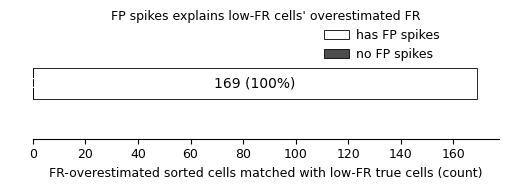

In [46]:
from matplotlib import pyplot as plt

# build histo dataset
data_df = pd.DataFrame(
    {
        "cell count": [
            n_with_fp_spike,
            n_without_fp_spike,
        ],
    },
    index=["has FP spikes", "no FP spikes"],
)

# set figure
fig, axis = plt.subplots(1, 1, figsize=(5, 2))

# set plot legend
# colors = [[0.87, 0.92, 0.96], "w"]
colors = ["w", [0.3, 0.3, 0.3]]
txt_colors = ["k", "w"]
percents = [percent_with_fp_spikes, percent_without_fp_spikes]

# plot
ax = data_df.T.plot.barh(
    ax=axis,
    stacked=True,
    color=colors,
    width=0.2,
    edgecolor="k",
    linewidth=0.6,
)

# set axis legend
ax.spines[["left", "right", "top"]].set_visible(False)
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(True)
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)
ax.set_xlabel("FR-overestimated sorted cells matched with low-FR true cells (count)", fontsize=9)
ax.legend(
    bbox_to_anchor=(0.6, 0.6),
    frameon=False,
    fontsize=9,
    handletextpad=0.6,
)
ax.set_title("FP spikes explains low-FR cells' overestimated FR", fontsize=9)
ax.tick_params(axis="both", which="major", labelsize=9)
plt.tight_layout()

# annotate bars with count by sorting error type
for p_i, patch in enumerate(ax.patches):
    width, height = patch.get_width(), patch.get_height()
    x, y = patch.get_xy()
    ax.text(
        x + width / 2,
        y + height / 2,
        "{:.0f} ({:.0f}%)".format(width, percents[p_i]*100),
        horizontalalignment="center",
        verticalalignment="center",
        color=txt_colors[p_i],
    )

In [40]:
OVERMERGED_SCORE = 0

overmerged_units = out["MatchingObject"].get_overmerged_units(overmerged_score=OVERMERGED_SCORE)

# count the overmerging conditions
n_overmerged = len(set(overmerged_units) & set(cell_matching["sorted_cell"][neg_p_bias_overestimated]))
n_not_overmerged = n_total - n_overmerged
percent_overmerged = n_overmerged/n_total*100
percent_not_overmerged = n_not_overmerged/n_total*100

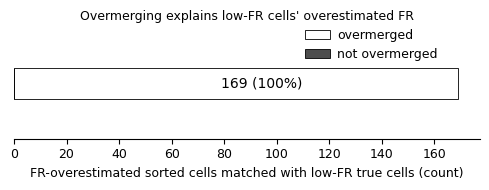

In [45]:
from matplotlib import pyplot as plt

# build histo dataset
data_df = pd.DataFrame(
    {
        "cell count": [
            n_overmerged,
            n_not_overmerged,
        ],
    },
    index=["overmerged", "not overmerged"],
)

# set figure
fig, axis = plt.subplots(1, 1, figsize=(5, 2))

# set plot legend
colors = ["w", [0.3, 0.3, 0.3]]
txt_colors = ["k", "k"]
percents = [percent_overmerged, percent_not_overmerged]

# plot
ax = data_df.T.plot.barh(
    ax=axis,
    stacked=True,
    color=colors,
    width=0.2,
    edgecolor="k",
    linewidth=0.6,
)

# set axis legend
ax.spines[["left", "right", "top"]].set_visible(False)
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(True)
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)
ax.set_xlabel("FR-overestimated sorted cells matched with low-FR true cells (count)", fontsize=9)
ax.legend(
    bbox_to_anchor=(0.6, 0.6),
    frameon=False,
    fontsize=9,
    handletextpad=0.6,
)
ax.set_title("Overmerging explains low-FR cells' overestimated FR", fontsize=9)
ax.tick_params(axis="both", which="major", labelsize=9)
plt.tight_layout()

# annotate bars with count by sorting error type
x_shift = 10
for p_i, patch in enumerate(ax.patches):
    width, height = patch.get_width(), patch.get_height()
    x, y = patch.get_xy()
    if not width==0:
        ax.text(
            x + width / 2 + x_shift,
            y + height / 2,
            "{:.0f} ({:.0f}%)".format(width, percents[p_i]),
            horizontalalignment="center",
            verticalalignment="center",
            color=txt_colors[p_i],
        )

Overmerged units have an agreement score above 0.2 with two or more ground-truth units [Buccino et al., 2020, p. 16].

In [32]:
print("overmerged score:", out["MatchingObject"].overmerged_score)
out["MatchingObject"].get_overmerged_units()

overmerged score: 0


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 33,
 34,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 73,
 74,
 75,
 76,
 77,
 78,
 80,
 81,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 